# LDA on nCovMemory articles' database, 2nd version

Import libraries

In [1]:
#import
import os
import numpy as np
import pandas as pd
import re
import itertools
from collections import Counter
import pickle
import jieba
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

reading dataframe of texts

In [2]:
df_texts = pd.read_csv('dataframe/df_texts_with_index.csv') #reading the dataframe with texts
df_texts.head()

,Unnamed: 0,id,texts
0,0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...
2,2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...
3,3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...
4,4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...


preparing to cut

In [3]:
with open('jieba_lists/UsrWords.txt', 'r', encoding='utf8') as f:
    custom_noun = f.readlines()
    for noun in custom_noun:
        jieba.add_word(noun.replace('\n', ''), freq=None, tag='n')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.489 seconds.
Prefix dict has been built successfully.


Cutting

In [4]:
df_texts['words'] = df_texts.texts.apply(jieba.lcut)
df_texts.head()

,Unnamed: 0,id,texts,words
0,0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,"[个, 临时, 发, 往, 武汉, 的, 口罩, \n, 个, 临时, 发, 往, 武汉, ..."
1,1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,"[武汉, 隔离, 疫区, 信息, 孤岛, 与, 一辆, 鄂车, 的, 漂流, \n, 武汉,..."
2,2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,"[我家, 离, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学..."
3,3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,"[疫情, 危机, 中, 不, 被, 看见, 的, 人们, 武汉, 周边城市, 百姓, 的, ..."
4,4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,"[孝感, 前线, 医生, 武汉, 更难, 我们, 下面, 不好意思, 提, 要求, \n, ..."


removing stopwords

In [6]:
fh = open("jieba_lists/stopwords.txt")
stopwords=[]
stopwords.append('\n') #append the '\n' in the beginning otherwise it would be erased by strip
stopwords.append('%')  #we append some special characters, I am also going to add it to the cleaning function pre-processing
stopwords.append('|')  #the texts but sometimes it does not catch them all
stopwords.append('△')
stopwords.append('▼')
stopwords.append('｜')
stopwords.append('\u3000') #this is a special empty space, I also removed tab space in the cleaning function, perhaps that'll help too
for line in fh:
    line = line.rstrip()
    stopwords.append(line)

def stp_removal(wordlist, stopwords=stopwords):
    lili=[]
    for word in wordlist:
        if word not in stopwords:
            lili.append(word)
    return lili

df_texts['words'] = df_texts.words.apply(stp_removal)
df_texts.head()

,Unnamed: 0,id,texts,words
0,0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,"[临时, 发, 武汉, 口罩, 临时, 发, 武汉, 口罩, 临时, 发, 武汉, 口罩, ..."
1,1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,"[武汉, 隔离, 疫区, 信息, 孤岛, 一辆, 鄂车, 漂流, 武汉, 隔离, 疫区, 信..."
2,2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,"[我家, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学生, ..."
3,3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,"[疫情, 危机, 看见, 武汉, 周边城市, 百姓, 自救, 行动, 疫情, 危机, 看见,..."
4,4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,"[孝感, 前线, 医生, 武汉, 更难, 下面, 不好意思, 提, 要求, 孝感, 前线, ..."


Import Mallet

In [7]:
import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'/home/bilatli/DEV/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'/home/bilatli/DEV/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

Preparing to LDA

In [24]:
data_lemmatized = df_texts.words

id2word = gensim.corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_above= 0.26) 

corpus = [id2word.doc2bow(doc) for doc in data_lemmatized]

def function to get best number of topics

In [25]:
def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
   coherence_values = []
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.wrappers.LdaMallet(
         mallet_path, corpus=corpus, num_topics=num_topics, iterations=1000, workers = 6, id2word=id2word
      )
      model_list.append(model)
      
      coherencemodel = CoherenceModel(
      model=model, texts=texts, dictionary=dictionary, coherence='c_v'
   )
      coherence_values.append(coherencemodel.get_coherence())
   return model_list, coherence_values

get best number of topics

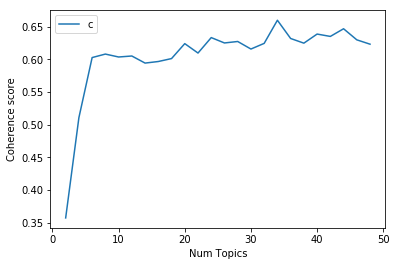

In [26]:
model_list, coherence_values = coherence_values_computation (
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=2, limit=50, step=2
)

limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

print coherence values

In [27]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 2  is having Coherence Value of 0.3574
Num Topics = 4  is having Coherence Value of 0.5108
Num Topics = 6  is having Coherence Value of 0.6027
Num Topics = 8  is having Coherence Value of 0.608
Num Topics = 10  is having Coherence Value of 0.6035
Num Topics = 12  is having Coherence Value of 0.605
Num Topics = 14  is having Coherence Value of 0.5942
Num Topics = 16  is having Coherence Value of 0.5966
Num Topics = 18  is having Coherence Value of 0.6011
Num Topics = 20  is having Coherence Value of 0.624
Num Topics = 22  is having Coherence Value of 0.6096
Num Topics = 24  is having Coherence Value of 0.6332
Num Topics = 26  is having Coherence Value of 0.625
Num Topics = 28  is having Coherence Value of 0.6272
Num Topics = 30  is having Coherence Value of 0.6157
Num Topics = 32  is having Coherence Value of 0.6243
Num Topics = 34  is having Coherence Value of 0.6597
Num Topics = 36  is having Coherence Value of 0.6318
Num Topics = 38  is having Coherence Value of 0.6247
N

check optimal model

In [45]:
optimal_model = model_list[3]

#or
#optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, iterations=1000, workers = 6, id2word=id2word)

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, iterations=1000, workers = 6, id2word=id2word)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.314497 -0.046528       1        1  20.039773
0      0.103241  0.115137       2        1  12.660096
6     -0.163008  0.214347       3        1  12.396269
5     -0.162326 -0.082084       4        1  12.204802
7      0.042925 -0.255186       5        1  11.496267
1      0.149162  0.103972       6        1  11.107253
4      0.180711 -0.078347       7        1  10.175745
3      0.163793  0.028690       8        1   9.919795, topic_info=       Term         Freq        Total Category  logprob  loglift
23611   意大利  6842.000000  6842.000000  Default  30.0000  30.0000
1599     护士  4422.000000  4422.000000  Default  29.0000  29.0000
5743     复工  6660.000000  6660.000000  Default  28.0000  28.0000
448      生产  4601.000000  4601.000000  Default  27.0000  27.0000
10712    韩国  3955.000000  3955.000000  Default  26.0000  26.0000
12093    登录  3962.000000  3962.000000  Default  25.0000  25.0000
521      行业  3731.000000  3731.000000  Default  24.0000  24.0000
2704     代表  3816.000000  3816.000000  Default  23.0000  23.0000
9641     日本  3598.000000  3598.000000  Default  22.0000  22.0000
3268     英国  3179.000000  3179.000000  Default  21.0000  21.0000
217      回复  4484.000000  4484.000000  Default  20.0000  20.0000
15433    方舱  4047.000000  4047.000000  Default  19.0000  19.0000
2410     病房  3445.000000  3445.000000  Default  18.0000  18.0000
208      员工  4328.000000  4328.000000  Default  17.0000  17.0000
4522     疫苗  2938.000000  2938.000000  Default  16.0000  16.0000
1572     床位  3238.000000  3238.000000  Default  15.0000  15.0000
2692     临床  3312.000000  3312.000000  Default  14.0000  14.0000
356      捐赠  2995.000000  2995.000000  Default  13.0000  13.0000
954     感染者  3753.000000  3753.000000  Default  12.0000  12.0000
23366    伊朗  3141.000000  3141.000000  Default  11.0000  11.0000
1868    传染病  3408.000000  3408.000000  Default  10.0000  10.0000
268      小区  4556.000000  4556.000000  Default   9.0000   9.0000
9038     观点  2865.000000  2865.000000  Default   8.0000   8.0000
1631     核酸  4407.000000  4407.000000  Default   7.0000   7.0000
1393     门诊  2727.000000  2727.000000  Default   6.0000   6.0000
1260     航班  2316.000000  2316.000000  Default   5.0000   5.0000
3110     德国  2270.000000  2270.000000  Default   4.0000   4.0000
6602     日记  3537.000000  3537.000000  Default   3.0000   3.0000
12913    欧洲  2607.000000  2607.000000  Default   2.0000   2.0000
2822     收治  3311.000000  3311.000000  Default   1.0000   1.0000
...     ...          ...          ...      ...      ...      ...
3268     英国  3087.473589  3179.047965   Topic8  -4.8325   2.2814
831      回国  1817.456090  1855.526336   Topic8  -5.3624   2.2899
19122    法国  1252.003066  1290.073313   Topic8  -5.7351   2.2807
10712    韩国  3688.955477  3955.447202   Topic8  -4.6545   2.2409
9641     日本  3218.578626  3598.805444   Topic8  -4.7909   2.1990
19540    航空   813.651873   846.312358   Topic8  -6.1660   2.2713
23610    总统   822.659089   857.642559   Topic8  -6.1550   2.2690
5159    留学生  1354.084851  1461.093111   Topic8  -5.6567   2.2346
35116   新天地   594.476276   615.054788   Topic8  -6.4799   2.2766
24409   特朗普  1423.140176  1581.594715   Topic8  -5.6070   2.2051
12913    欧洲  2220.779220  2607.655238   Topic8  -5.1620   2.1500
3377     乘客  1725.382323  1989.236782   Topic8  -5.4144   2.1683
23366    伊朗  2542.036601  3141.900214   Topic8  -5.0269   2.0988
1261   航空公司   674.540421   720.515871   Topic8  -6.3535   2.2447
1069     机场  1741.395152  2262.112105   Topic8  -5.4051   2.0490
8796     入境  1585.270069  2065.778315   Topic8  -5.4991   2.0459
1044     旅客  1135.910056  1404.193230   Topic8  -5.8324   2.0986
9680     纽约  1056.846713  1296.586373   Topic8  -5.9045   2.1062
8929     旅行   889.712810  1050.835225   Topic8  -6.0767   2.1442
4212     关闭  1505.205925  2294.770077   Topic8  -5.5509   1.8889
3189     民众  1346.078436  1980.621768

saving topic analysis

In [29]:
vis = pyLDAvis.prepared_data_to_html(vis)
with open("OUTPUT/3LDA_output8s-026.html", "w") as file:
    file.write(vis)

saving word list forming topic

In [32]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

with open("OUTPUT/2LDAwordlist10s.txt", "w") as file:
    file.write(str(optimal_model.print_topics(num_words=30)))

[(0,
  '0.009*"登录" + 0.009*"代表" + 0.007*"观点" + 0.005*"博客" + 0.005*"金融" + 0.004*"政经" '
  '+ 0.004*"网友" + 0.004*"投资" + 0.004*"发表" + 0.004*"最新" + 0.004*"微博" + '
  '0.004*"科技" + 0.004*"会议" + 0.004*"课" + 0.004*"数字" + 0.004*"复工" + '
  '0.004*"个人观点" + 0.003*"私房" + 0.003*"更新" + 0.003*"账号" + 0.003*"市民" + '
  '0.003*"戳" + 0.003*"文化" + 0.003*"组图" + 0.003*"民生" + 0.003*"专题" + 0.003*"回复" '
  '+ 0.003*"财" + 0.003*"指数" + 0.003*"快捷"'),
 (1,
  '0.018*"意大利" + 0.009*"韩国" + 0.008*"日本" + 0.008*"英国" + 0.007*"伊朗" + '
  '0.006*"航班" + 0.006*"德国" + 0.006*"欧洲" + 0.005*"回国" + 0.004*"机场" + 0.004*"乘客" '
  '+ 0.004*"入境" + 0.004*"关闭" + 0.004*"香港" + 0.004*"特朗普" + 0.004*"取消" + '
  '0.004*"输入" + 0.004*"留学生" + 0.003*"民众" + 0.003*"学校" + 0.003*"西班牙" + '
  '0.003*"邮轮" + 0.003*"法国" + 0.003*"境外" + 0.003*"旅客" + 0.003*"国际" + 0.003*"纽约" '
  '+ 0.003*"海外" + 0.003*"华人" + 0.002*"蔓延"'),
 (2,
  '0.007*"志愿者" + 0.006*"捐赠" + 0.006*"酒店" + 0.005*"居民" + 0.005*"小区" + '
  '0.004*"司机" + 0.003*"指挥部" + 0.003*"昼" + 0.003*"车辆" + 0.003*"单位" + 0.003

Or we can also save it as dataframe since we are going to translate the terms in a spreadsheet. We can also see that the topic number is not consistent from one time to another. We will have to rename them based on the VIS representation while translating.

In [79]:
topics = [[(term, round(wt, 3)) for term, wt in optimal_model.show_topic(n, topn=30)] for n in range(0, optimal_model.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 31)], index=['Topic '+str(t) for t in range(1, optimal_model.num_topics+1)]).T

topics_df.to_csv(r'dataframe/3LDAtopics8s-026.csv',index = True, header=True)

topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
Term1,登录,意大利,孩子,生产,护士,居民,临床,回复
Term2,代表,韩国,小区,复工,志愿者,小区,感染者,日记
Term3,观点,日本,妈妈,员工,方舱,疑似病例,疫苗,心理
Term4,金融,英国,母亲,行业,病房,排查,传染病,老师
Term5,博客,伊朗,超市,产品,床位,复工,核酸,学生


Let's see if we can add dominant topic per document. After that we will be able to choose what documents to translate based on that, at least partially.


convert mallet to lda gensim

In [34]:
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [36]:
ldagensim = convertldaMalletToldaGen(optimal_model)

get dominant topic

In [37]:
def format_topics_sentences(ldamodel=ldagensim, corpus=corpus, texts=df_texts.texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldagensim, corpus=corpus, texts=df_texts.texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.3144,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,1,6.0,0.6748,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...
2,2,6.0,0.6799,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...
3,3,6.0,0.4359,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...
4,4,6.0,0.3613,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...
5,5,7.0,0.4510,"护士, 方舱, 病房, 床位, 收治, 出院, 门诊, 核酸, 医疗队, 救治",恐慌很正常当疫情结束才是心理问题高发期\n恐慌很正常当疫情结束才是心理问题高发期恐慌很正常当...
6,6,6.0,0.3953,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",外卖骑手出租车司机快递员志愿者封城九日他们维护着武汉的血脉\n外卖骑手出租车司机快递员志愿者...
7,7,7.0,0.3859,"护士, 方舱, 病房, 床位, 收治, 出院, 门诊, 核酸, 医疗队, 救治",疫情中的心理援助寻找局部的安全\n疫情中的心理援助寻找局部的安全疫情中的心理援助寻找局部的安...
8,8,6.0,0.5684,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",鸡在瘟疫蔓延时\n鸡在瘟疫蔓延时鸡在瘟疫蔓延时鸡在瘟疫蔓延时蔚琳颖迪呈杰敏洁报道报道记录人物...
9,9,6.0,0.7990,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",武汉封城后的宠物营救计划人类犯错的后果不该由它们承担\n武汉封城后的宠物营救计划人类犯错的后...


we can add our id column for easy check and selection

In [38]:
contents = pd.Series(df_texts.id)
newdf = pd.concat([df_dominant_topic, contents], axis=1)
newdf.head()


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
0,0,6.0,0.3144,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,1
1,1,6.0,0.6748,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,2
2,2,6.0,0.6799,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,3
3,3,6.0,0.4359,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,4
4,4,6.0,0.3613,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,5


and see the dominant topic distribution amongs the articles

In [39]:
dominant_topic_df = pd.DataFrame()

xx = newdf.groupby(by='Dominant_Topic').size()
dominant_topic_df['Doc_Count'] = xx
dominant_topic_df['Total_Docs_Perc'] = xx
dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))


dominant_topic_df

,Doc_Count,Total_Docs_Perc
Dominant_Topic,,
0.0,344,7.10
1.0,704,14.53
2.0,584,12.05
3.0,495,10.22
4.0,471,9.72
5.0,352,7.27
6.0,1394,28.77
7.0,501,10.34


In [40]:
dominant_topic_df.Doc_Count.sum()

4845

Let's find out which are the most representative documents for each subjects

In [53]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
   sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
# not reseting the index let us find easily which articles it is
#sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text"
]
sent_topics_sorteddf_mallet

,Topic_Number,Contribution_Perc,Keywords,Text
3868,0.0,0.8862,"登录, 代表, 观点, 博客, 金融, 政经, 网友, 投资, 发表, 最新",疫情总动员各地怎么做保交通重问责迟开学政经频道财新网\n疫情总动员各地怎么做保交通重问责迟开...
4245,1.0,0.8489,"意大利, 韩国, 日本, 英国, 伊朗, 航班, 德国, 欧洲, 回国, 机场",超家航空公司已停飞所有国际航线\n超家航空公司已停飞所有国际航线超家航空公司已停飞所有国际航...
1423,2.0,0.9231,"志愿者, 捐赠, 酒店, 居民, 小区, 司机, 指挥部, 昼, 车辆, 单位",愼愼挼昼搼昼挼昼戼戼搼昼挼戼昼挼搼搼搼挼戼戼愼愼愼戼攼挼攼戼搼挼昼戼愼挼戼挼搼挼挼挼搼挼昼戼...
1827,3.0,0.8875,"感染者, 疫苗, 临床, 传染病, 疾控中心, 无症状, 药物, 公共卫生, 卫健委, 核酸",华南海鲜市场不是病毒发源地中科院团队基因追踪零号病人再进一步\n华南海鲜市场不是病毒发源地中...
3150,4.0,0.9212,"复工, 生产, 员工, 行业, 产品, 工厂, 销售, 价格, 订单, 消费",病毒对石油煤炭有色冲击巨大钢铁却比往年更红火\n病毒对石油煤炭有色冲击巨大钢铁却比往年更红火...
2890,5.0,0.7899,"回复, 学生, 游戏, 老师, 直播, 在线, 微博, 线上, 用户, 办公",一场百万人的云考试无人监考\n一场百万人的云考试无人监考一场百万人的云考试无人监考一场百万人...
1880,6.0,0.9005,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",疫情让我出了柜\n疫情让我出了柜疫情让我出了柜疫情让我出了柜乐点乐点乐点独立杂志关注性少数群...
2776,7.0,0.8396,"护士, 方舱, 病房, 床位, 收治, 出院, 门诊, 核酸, 医疗队, 救治",这支护肾小队专门对付炎症风暴\n这支护肾小队专门对付炎症风暴这支护肾小队专门对付炎症风暴这支...


since we kept the original index, we can find the articles like this:

In [52]:
df_texts[df_texts.index == 3868]

,Unnamed: 0,id,texts,words
3868,3868,3898,疫情总动员各地怎么做保交通重问责迟开学政经频道财新网\n疫情总动员各地怎么做保交通重问责迟开...,"[疫情, 总动员, 各地, 做保, 交通, 重问, 责迟, 开学, 政经, 频道, 疫情, ..."


Or we can merge with original dataframe (df_texts) based on indexd to get the id for all of them

In [66]:
representative = pd.merge(sent_topics_sorteddf_mallet, df_texts,left_index=True, right_index=True ,how="left")
#let's keep only what we need
representative = representative[['id','Topic_Number', 'Contribution_Perc','Keywords', 'Text']]
representative

,id,Topic_Number,Contribution_Perc,Keywords,Text
3868,3898,0.0,0.8862,"登录, 代表, 观点, 博客, 金融, 政经, 网友, 投资, 发表, 最新",疫情总动员各地怎么做保交通重问责迟开学政经频道财新网\n疫情总动员各地怎么做保交通重问责迟开...
4245,4282,1.0,0.8489,"意大利, 韩国, 日本, 英国, 伊朗, 航班, 德国, 欧洲, 回国, 机场",超家航空公司已停飞所有国际航线\n超家航空公司已停飞所有国际航线超家航空公司已停飞所有国际航...
1423,1440,2.0,0.9231,"志愿者, 捐赠, 酒店, 居民, 小区, 司机, 指挥部, 昼, 车辆, 单位",愼愼挼昼搼昼挼昼戼戼搼昼挼戼昼挼搼搼搼挼戼戼愼愼愼戼攼挼攼戼搼挼昼戼愼挼戼挼搼挼挼挼搼挼昼戼...
1827,1844,3.0,0.8875,"感染者, 疫苗, 临床, 传染病, 疾控中心, 无症状, 药物, 公共卫生, 卫健委, 核酸",华南海鲜市场不是病毒发源地中科院团队基因追踪零号病人再进一步\n华南海鲜市场不是病毒发源地中...
3150,3177,4.0,0.9212,"复工, 生产, 员工, 行业, 产品, 工厂, 销售, 价格, 订单, 消费",病毒对石油煤炭有色冲击巨大钢铁却比往年更红火\n病毒对石油煤炭有色冲击巨大钢铁却比往年更红火...
2890,2914,5.0,0.7899,"回复, 学生, 游戏, 老师, 直播, 在线, 微博, 线上, 用户, 办公",一场百万人的云考试无人监考\n一场百万人的云考试无人监考一场百万人的云考试无人监考一场百万人...
1880,1897,6.0,0.9005,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",疫情让我出了柜\n疫情让我出了柜疫情让我出了柜疫情让我出了柜乐点乐点乐点独立杂志关注性少数群...
2776,2797,7.0,0.8396,"护士, 方舱, 病房, 床位, 收治, 出院, 门诊, 核酸, 医疗队, 救治",这支护肾小队专门对付炎症风暴\n这支护肾小队专门对付炎症风暴这支护肾小队专门对付炎症风暴这支...


let's save it as dataframe just in case, but without the column Text

In [67]:
representativeX = representative[['id','Topic_Number', 'Contribution_Perc','Keywords']]
representativeX.to_csv(r'dataframe/most_representative.csv', index = True, header=True)

Now, let's check what categories are the articles that we already translated

In [68]:
newdf[newdf.id == 1441 ] #titre français: 7.1.1	S’il vous plaît, ne me dérangez pas

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
1424,1424,6.0,0.6281,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",武汉方舱医院一个护士的诗\n武汉方舱医院一个护士的诗武汉方舱医院一个护士的诗武汉方舱医院一个...,1441


In [69]:
newdf[newdf.id == 3655 ] #titre français:7.1.2	Immunisé contre l’annonce de la fin du confinement | Le journal de confinement de Guo Jing

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
3628,3628,6.0,0.6633,"孩子, 妈妈, 母亲, 写, 日记, 父母, 超市, 小区, 群里, 父亲",对解封的消息免疫郭晶的武汉封城日记\n对解封的消息免疫郭晶的武汉封城日记对解封的消息免疫郭晶...,3655


In [70]:
newdf[newdf.id == 3315 ] #titre français: 7.1.3	Un camion poubelle utilisé pour livrer de la viande bon marché dans un quartier de Wuhan : deux employés ont été démis de leurs fonctions.

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
3288,3288,2.0,0.6003,"志愿者, 捐赠, 酒店, 居民, 小区, 司机, 指挥部, 昼, 车辆, 单位",武汉一社区用环卫车运送平价肉人被免职青山区纪委界面新闻青山区纪委官网消息年月日时许青山区委区...,3315


Now, we can use our most representative articles' list to choose what article to translate and therefore check if the themes make sense.
